In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from omegaconf import ListConfig
import einops

# Helpers

In [3]:
import typing as T

import math
from tqdm import tqdm, trange
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch.optim import AdamW
import lightning as L
import wandb
import pandas as pd
from omegaconf import ListConfig

from plaid.datasets import CATHShardedDataModule
from plaid.transforms import trim_or_pad_batch_first
from plaid.esmfold.misc import batch_encode_sequences
from plaid.utils import LatentScaler, get_lr_scheduler
from plaid.proteins import LatentToSequence, LatentToStructure
from plaid.losses.modules import SequenceAuxiliaryLoss, BackboneAuxiliaryLoss
from plaid.losses.functions import masked_token_accuracy, masked_token_cross_entropy_loss


# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def pad_to_multiple(tensor, multiple, dim = -1, value = 0):
    seq_len = tensor.shape[dim]
    m = seq_len / multiple
    if m.is_integer():
        return tensor
    remainder = math.ceil(m) * multiple - seq_len
    pad_offset = (0,) * (-1 - dim) * 2
    return F.pad(tensor, (*pad_offset, 0, remainder), value = value)

def cast_tuple(val, depth = 1):
    return val if isinstance(val, tuple) else ((val,) * depth)

# factory
def _valid_depth_dtype(depth):
    if isinstance(depth, int):
        return True
    if isinstance(depth, tuple) or isinstance(depth, list) or isinstance(depth, ListConfig):
        if len(depth) == 3:
            return True
    return False

def _check_if_nest(var):
    return isinstance(var, (tuple, list, ListConfig)) and len(var) > 0

# up and down sample classes

class NaiveDownsample(nn.Module):
    def __init__(self, shorten_factor):
        super().__init__()
        self.shorten_factor = shorten_factor

    def forward(self, x):
        return reduce(x, 'b (n s) d -> b n d', 'mean', s = self.shorten_factor)

class NaiveUpsample(nn.Module):
    def __init__(self, elongate_factor):
        super().__init__()
        self.elongate_factor = elongate_factor

    def forward(self, x):
        return repeat(x, 'b n d -> b (n s) d', s = self.elongate_factor)

class LinearDownsample(nn.Module):
    def __init__(self, dim, shorten_factor):
        super().__init__()
        self.proj = nn.Linear(dim * shorten_factor, dim)
        self.shorten_factor = shorten_factor

    def forward(self, x):
        x = rearrange(x, 'b (n s) d -> b n (s d)', s = self.shorten_factor)
        return self.proj(x)

class LinearUpsample(nn.Module):
    def __init__(self, dim, elongate_factor):
        super().__init__()
        self.proj = nn.Linear(dim, dim * elongate_factor)
        self.elongate_factor = elongate_factor

    def forward(self, x):
        x = self.proj(x)
        return rearrange(x, 'b n (s d) -> b (n s) d', s = self.elongate_factor)

# classes

class PreNormLinearDownProjection(nn.Module):
    def __init__(self, dim, downproj_factor):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.proj = nn.Linear(dim, dim // downproj_factor)

    def forward(self, x):
        return self.proj(self.norm(x))

class PreNormLinearUpProjection(nn.Module):
    def __init__(self, dim, upproj_factor):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.proj = nn.Linear(dim, dim * upproj_factor)

    def forward(self, x):
        return self.proj(self.norm(x))

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs) + x

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 64,
        dropout = 0.,
        causal = False
    ):
        super().__init__()
        self.heads = heads
        self.causal = causal
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context = None, mask = None):
        h, device = self.heads, x.device
        kv_input = default(context, x)

        q, k, v = self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        mask_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = rearrange(mask, 'b j -> b () () j')
            sim = sim.masked_fill(~mask, mask_value)

        if self.causal:
            i, j = sim.shape[-2:]
            mask = torch.ones(i, j, device = device, dtype = torch.bool).triu_(j - i + 1)
            mask = rearrange(mask, 'i j -> () () i j')
            sim = sim.masked_fill(mask, mask_value)

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

def FeedForward(dim, mult = 4, dropout = 0.):
    return nn.Sequential(
        nn.Linear(dim, dim * mult),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

# transformer classes

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth,
        causal = False,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_mult = 4,
        ff_dropout = 0.,
        norm_out = False,
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNormResidual(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout, causal = causal)),
                PreNormResidual(dim, FeedForward(dim, mult = ff_mult, dropout = ff_dropout))
            ]))

        self.norm = nn.LayerNorm(dim) if norm_out else nn.Identity()

    def forward(self, x, context = None, mask = None, compressed = None):
        for attn, ff in self.layers:
            x = attn(x, context = context, mask = mask)
            x = ff(x)

        return self.norm(x)

# Hourglass Encoder

In [4]:
class HourglassEncoder(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth=(4, 4),
        shorten_factor = (2, 2),
        downproj_factor = (2, 2),
        attn_resampling = True,
        updown_sample_type = 'naive',
        heads = 8,
        dim_head = 64,
        causal = False,
        norm_out = False,
    ):
        super().__init__()

        # shorten factor
        if isinstance(shorten_factor, (tuple, list, ListConfig)):
            assert len(depth) == len(shorten_factor) == len(downproj_factor)
            shorten_factor, *rest_shorten_factor = shorten_factor
        elif isinstance(shorten_factor, int):
            shorten_factor, rest_shorten_factor = shorten_factor, None
        else:
            raise TypeError()

        # downproj factor
        if isinstance(downproj_factor, (tuple, list, ListConfig)):
            downproj_factor, *rest_downproj_factor = downproj_factor
        elif isinstance(downproj_factor, int):
            downproj_factor, rest_downproj_factor = downproj_factor, None
        else:
            raise TypeError()

        # depth 
        if isinstance(depth, (tuple, list, ListConfig)):
            depth, *rest_depth = depth
        elif isinstance(depth, int):
            depth, rest_depth = depth, None
        else:
            raise TypeError()

        # shared transformer kwargs
        transformer_kwargs = dict(
            heads = heads,
            dim_head = dim_head
        )

        self.causal = causal
        self.shorten_factor = shorten_factor
        self.downproj_factor = downproj_factor

        if updown_sample_type == 'naive':
            self.downsample = NaiveDownsample(shorten_factor)
        elif updown_sample_type == 'linear':
            self.downsample = LinearDownsample(dim, shorten_factor)
        else:
            raise ValueError(f'unknown updown_sample_type keyword value - must be either naive or linear for now')

        self.down_projection = PreNormLinearDownProjection(dim, downproj_factor)
        if _check_if_nest(rest_depth):
            assert _check_if_nest(rest_shorten_factor)
            assert _check_if_nest(rest_downproj_factor)
            self.nested_encoder = HourglassEncoder(
                dim = dim // downproj_factor,
                shorten_factor = rest_shorten_factor,
                downproj_factor = rest_downproj_factor,
                depth = rest_depth,
                attn_resampling = attn_resampling,
                updown_sample_type = updown_sample_type,
                causal = causal,
                **transformer_kwargs
            )
            self.has_nest = True 
        else:
            self.has_nest = False

        self.pre_transformer = Transformer(dim = dim, depth = depth, causal = causal, **transformer_kwargs)
        self.attn_resampling_pre_valley = Transformer(dim = dim, depth = 1, **transformer_kwargs) if attn_resampling else None
        self.norm_out = nn.LayerNorm(dim) if norm_out else nn.Identity()

    def forward(self, x, mask = None):
        """
        x: input
        mask: indicates if input has a padding (True if we should keep it, False if it's padding & we should discard it)
        compressed: at the start, should be None; if it's already populated, ignore further actions at the valley step
        """
        if x.shape[1] % self.shorten_factor != 0:
            raise ValueError("Length of input `x` must be a multiple of `self.shorten_factor` for attention resampling")

        # b : batch, n : sequence length, d : feature dimension, s : shortening factor
        s, b, n = self.shorten_factor, *x.shape[:2]

        # top half of hourglass, pre-transformer layers
        x = self.pre_transformer(x, mask = mask)

        # pad to multiple of shortening factor, in preparation for pooling
        x = pad_to_multiple(x, s, dim = -2)

        # print(mask)
        if exists(mask):
            padded_mask = pad_to_multiple(mask, s, dim = -1, value = False)
        # print(padded_mask)
            

        # save the residual, and for "attention resampling" at downsample and upsample
        x_residual = x.clone()

        # if autoregressive, do the shift by shortening factor minus one
        if self.causal:
            shift = s - 1
            x = F.pad(x, (0, 0, shift, -shift), value = 0.)

            if exists(mask):
                padded_mask = F.pad(padded_mask, (shift, -shift), value = False)

        # naive average pool along length dimension
        downsampled = self.downsample(x)
        if exists(mask):
            downsampled_mask = reduce(padded_mask, 'b (n s) -> b n', 'sum', s = s) > 0
        else:
            downsampled_mask = None
        # print('down sampled mask', downsampled_mask)

        # pre-valley "attention resampling" - they have the pooled token in each bucket attend to the tokens pre-pooled
        if exists(self.attn_resampling_pre_valley):
            if exists(mask):
                attn_resampling_mask = rearrange(padded_mask, 'b (n s) -> (b n) s', s = s)
            else:
                attn_resampling_mask = None
            downsampled = self.attn_resampling_pre_valley(
                rearrange(downsampled, 'b n d -> (b n) () d'),
                rearrange(x, 'b (n s) d -> (b n) s d', s = s),
                mask = attn_resampling_mask
            )

            downsampled = rearrange(downsampled, '(b n) () d -> b n d', b = b)
            
        # also possibly reduce along dim=-1
        out = self.down_projection(downsampled)

        # the "valley" - either a regular transformer or another hourglass
        if self.has_nest: 
            out, downsampled_mask = self.nested_encoder(out, mask = downsampled_mask)
        
        return self.norm_out(out), downsampled_mask


In [5]:
shortenf = 2
downprojf = 2
enc = HourglassEncoder(
    dim=1024,
    depth=4,
    shorten_factor=shortenf,
    downproj_factor=downprojf,
    attn_resampling=True,
    updown_sample_type="linear"
)

In [6]:
device = torch.device("cuda")
enc.to(device)
emb = torch.randn((4,8,1024)).to(device)
mask = einops.repeat(torch.tensor([1,1,1,1,1,0,0,0]), "l -> n l", n=4).bool().to(device)
mask

tensor([[ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False]],
       device='cuda:0')

In [7]:
ze, downsampled_mask = enc(emb,mask)

In [8]:
print(ze.shape)
print(downsampled_mask.shape)

torch.Size([4, 4, 512])
torch.Size([4, 4])


# Quantizers

## Vector-Quantized

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def expand_to_shape(x, target_shape):
    # keep adding dimensions to the end until we match target dimensions
    while len(x.shape) < len(target_shape):
        x = x[..., None]
    return x.expand(target_shape)



class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, length, channel)

        quantization pipeline:

            1. get encoder input (B,L,C)
            2. flatten input to (B*L,C)

        """
        # reshape z -> (batch, height, channel) and flatten
        z_flattened = einops.rearrange(z, "b l c -> (b l) c").view(-1, self.e_dim)
        device = z.device

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        # embedding_loss = masked_mse_loss(z_q.detach(), z, mask)
        # commitment_loss = masked_mse_loss(z_q, z.detach(), mask)
        # loss = embedding_loss + self.beta * commitment_loss
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        return {
            "loss": loss,
            "z_q": z_q,
            "perplexity": perplexity,
            "min_encodings": min_encodings,
            "min_encoding_indices": min_encoding_indices
        }

    def get_codebook_entry(self, indices, shape=None):
        # shape specifying (batch, length, channel)
        # TODO: check for more easy handling with nn.Embedding
        min_encodings = torch.zeros(indices.shape[0], self.n_e).to(indices)
        min_encodings.scatter_(1, indices[:,None], 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings.float(), self.embedding.weight)

        if shape is not None:
            z_q = z_q.view(shape)
        return z_q

In [10]:
n_e = 16
e_dim = 64
quantizer = VectorQuantizer(n_e, e_dim, 0.25)
quantizer = quantizer.to(device)
quant_outputs = quantizer(ze)

In [11]:
for k, v in quant_outputs.items():
    print(k, v.shape) 

loss torch.Size([])
z_q torch.Size([4, 4, 512])
perplexity torch.Size([])
min_encodings torch.Size([128, 16])
min_encoding_indices torch.Size([128, 1])


In [12]:
z_q = quant_outputs['z_q']

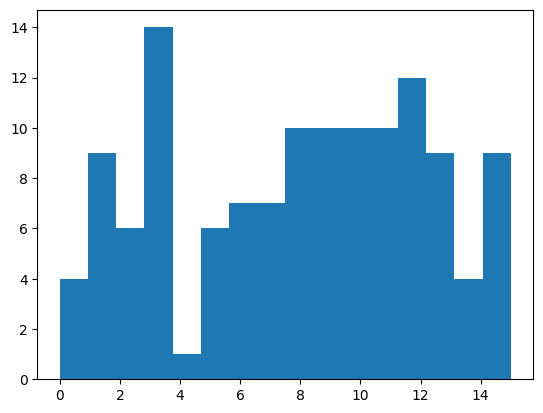

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(quant_outputs['min_encoding_indices'].detach().cpu().numpy(), bins=16)
fig.show()

In [22]:
type(fig)

matplotlib.figure.Figure

# Decoder 

In [13]:
class HourglassDecoder(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth=(4, 4),
        elongate_factor = (2, 2),
        upproj_factor = (2, 2),
        attn_resampling = True,
        updown_sample_type = 'linear',
        heads = 8,
        dim_head = 64,
        causal = False,
        norm_out = False,
    ):
        super().__init__()

        # set up nesting
        if isinstance(elongate_factor, (tuple, list, ListConfig)):
            assert len(depth) == len(elongate_factor) == len(upproj_factor)
            elongate_factor, *rest_elongate_factor = elongate_factor
        elif isinstance(elongate_factor, int):
            elongate_factor, rest_elongate_factor = elongate_factor, None
        else:
            raise TypeError()

        if isinstance(upproj_factor, (tuple, list, ListConfig)):
            upproj_factor, *rest_upproj_factor = upproj_factor
        elif isinstance(upproj_factor, int):
            upproj_factor, rest_upproj_factor = upproj_factor, None
        else:
            raise TypeError()

        if isinstance(depth, (tuple, list, ListConfig)):
            depth, *rest_depth = depth
        elif isinstance(depth, int):
            depth, rest_depth = depth, None
        else:
            raise TypeError()

        # shared transformer kwargs
        transformer_kwargs = dict(
            heads = heads,
            dim_head = dim_head
        )

        self.causal = causal
        self.elongate_factor = elongate_factor
        self.upproj_factor = upproj_factor

        if updown_sample_type == 'naive':
            self.upsample = NaiveUpsample(elongate_factor)
        elif updown_sample_type == 'linear':
            self.upsample = LinearUpsample(dim, elongate_factor)
        else:
            raise ValueError(f'unknown updown_sample_type keyword value - must be either naive or linear for now')

        self.up_projection = PreNormLinearUpProjection(dim, upproj_factor)
        if _check_if_nest(rest_depth):
            assert _check_if_nest(rest_elongate_factor)
            assert _check_if_nest(rest_upproj_factor)
            self.nested_decoder = HourglassDecoder(
                dim = dim * upproj_factor,
                elongate_factor = rest_elongate_factor,
                upproj_factor = rest_upproj_factor,
                depth = rest_depth,
                attn_resampling = attn_resampling,
                updown_sample_type = updown_sample_type,
                causal = causal,
                **transformer_kwargs
            )
            self.has_nest = True 
        else:
            self.has_nest = False

        self.post_transformer = Transformer(dim = dim * elongate_factor, depth = depth, causal = causal, **transformer_kwargs)
        self.attn_resampling_post_valley = Transformer(dim = dim, depth = 1, **transformer_kwargs) if attn_resampling else None
        self.norm_out = nn.LayerNorm(dim) if norm_out else nn.Identity()

    def forward(self, z_q, mask = None, original_length = None):
        """
        z_q: input compressed representation
        mask: indicates if input has a padding (True if we should keep it, False if it's padding & we should discard it)
        compressed: at the start, should be None; if it's already populated, ignore further actions at the valley step
        """
        # b : batch, n : sequence length, d : feature dimension, s : elongation factor
        s, b, n = self.elongate_factor, *z_q.shape[:2]

        # print("z_q", z_q.shape)
        upsampled = self.upsample(z_q)
        # print("upsampled", upsampled.shape)
        # print(mask)
        
        # pad to multiple of shortening factor, in preparation for pooling
        # z_q = pad_to_multiple(z_q, s, dim = -2)
        # print('post pad maybe', z_q.shape)
        # need to just ensure that input length is always a multiple of 2...

        # naive repeat to upsample mask
        if exists(mask):
            # print("masks", mask.shape)
            # padded_mask = pad_to_multiple(mask, s, dim = -1, value = False)
            # print("padded mask", padded_mask)
            upsampled_mask = einops.repeat(mask, 'b n -> b (n s)', s = s) > 0
            # print("upsampled mask", upsampled_mask)
        else:
            upsampled_mask = None
        
        # post-valley "attention resampling"
        if exists(self.attn_resampling_post_valley):
            x = self.attn_resampling_post_valley(
                rearrange(upsampled, 'b (n s) d -> (b n) s d', s = s),
                rearrange(z_q, 'b n d -> (b n) () d')
            )
            x = rearrange(x, '(b n) s d -> b (n s) d', b = b)
        # print("x.shape", x.shape)
        x = self.up_projection(x)
        # print("x.shape", x.shape)

        # bring sequence back to original length, if it were padded for pooling
        if not original_length is None:
            x = x[:, :original_length]
        # print(x.shape)

        # post-valley transformers
        out = self.post_transformer(x, mask = upsampled_mask)
        # print(out.shape)

        if self.has_nest: 
            out = self.nested_decoder(out, mask = upsampled_mask)
        
        return self.norm_out(out)


In [14]:
dec = HourglassDecoder(
    dim=1024 // downprojf,
    depth=4,
    elongate_factor=shortenf,
    upproj_factor=downprojf,
    attn_resampling=True,
    updown_sample_type="linear"
)
dec = dec.to(device)

In [15]:
x_recons = dec(z_q, downsampled_mask)

#  Training

## Dataloading

In [16]:
from plaid.datasets import CATHShardedDataModule

shard_dir = "/homefs/home/lux70/storage/data/cath/shards/"
dm = CATHShardedDataModule(
    shard_dir=shard_dir
)
dm.setup()
train_dataloader = dm.train_dataloader()
batch = next(iter(train_dataloader))

In [17]:
from plaid.esmfold.misc import batch_encode_sequences
x = batch[0]
_, mask, _, _, _ = batch_encode_sequences(batch[1])
x = x.to(device)
mask = mask.to(device).bool()

In [ ]:
from torch.optim import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(
    list(enc.parameters()) + list(quantizer.parameters()) + list(dec.parameters()), lr=1e-4
)

# wandb.init(
#     entity="lu-amy-al1",
#     project="plaid-hourglass-vqvae",
# )

vq_losses = []
perps = []
recons_losses = []
losses = []

n_epochs=80
for epoch in range(n_epochs): 
    for batch in tqdm(train_dataloader, desc=f"epoch {epoch}"):
        ze, ze_mask = enc(x, mask)
        quant_out = quantizer(ze)
        zq = quant_out['z_q']
        vq_loss = quant_out['loss']
        # print(vq_loss)
        # print(quant_out['perplexity'])
        # print(quant_out)
        x_recons = dec(zq, ze_mask) 
        
        recons_loss = torch.mean((x_recons - x) ** 2)
        loss = vq_loss + recons_loss
        # print(loss)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        vq_losses.append(vq_loss.item())
        perps.append(quant_out['perplexity'].item())
        recons_losses.append(recons_loss.item())
        losses.append(loss.item())
        
        # wandb.log({
        #     "vq_loss": vq_loss,
        #     "vq_perplexity": quant_out['perplexity'],
        #     "recons_loss": recons_loss,
        #     "loss": loss
        # })

epoch 0:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 8:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 9:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 10:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 11:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 12:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 13:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 14:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 15:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 16:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 17:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 18:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 19:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 20:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 21:   0%|          | 0/798 [00:00<?, ?it/s]

epoch 22:   0%|          | 0/798 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
print(np.min(recons_losses))
plt.plot(recons_losses)

In [ ]:
torch.save(enc.state_dict(), "hourglass_vq_enc.ckpt")